In [1]:
from pyspark.sql import SparkSession
import glob
import numpy as np
import pandas as pd
import os
import concurrent.futures
from tqdm import tqdm

In [2]:
#Set Environment accordingly
os.environ['JAVA_HOME'] = "/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home/"
os.environ['SPARK_HOME'] = "/Users/simran/Downloads/spark-3.5.5-bin-hadoop3/"

In [ ]:
!wget "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_price/full_history.zip"
!unzip "./full_history.zip" -d "./"

In [ ]:
#Preprocess Data before reading to Spark

directory_path = "./full_history"
file_pattern = "*.csv"
desired_order = ['date','volume','open','high','low','close','adj close']
new_order = ['date','volume','open','high','low','close','adj close','StockName']
def amendCSV(filename):
  df = pd.read_csv(filename, usecols=desired_order)
  stockName = filename
  df['StockName'] = stockName.split("/")[-1].split(".csv")[0]  # Add filename column
  df.to_csv(filename,index=False,columns=new_order)
  return 1

all_files = glob.glob(os.path.join(directory_path, file_pattern), recursive=True)
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
  result = list(tqdm(executor.map(amendCSV, all_files), total = len(all_files)))
print('All done.')

In [3]:
#Data Collection
directory_path = "./full_history"
file_pattern = "*.csv"
# Initialize Spark session
spark = SparkSession.builder \
    .appName("BigDataProject1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()




# Load datasets as DataFrames
history_df = spark.read.format("csv") \
     .option("header", "true") \
     .option("inferSchema", "true") \
     .load(f"{directory_path}/{file_pattern}")


history_df.show(5)

25/04/14 13:52:51 WARN Utils: Your hostname, Simrans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.222 instead (on interface en0)
25/04/14 13:52:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/14 13:52:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+---------+-----------------+------------------+------------------+------------------+------------------+---------+
|      date|   volume|             open|              high|               low|             close|         adj close|StockName|
+----------+---------+-----------------+------------------+------------------+------------------+------------------+---------+
|2023-12-28|5703600.0|30.14999961853028|30.239999771118164|29.950000762939453| 30.18000030517578| 30.18000030517578|      HPQ|
|2023-12-27|5127900.0|30.39999961853028|30.520000457763672|30.209999084472656|30.239999771118164|30.239999771118164|      HPQ|
|2023-12-26|4853600.0|30.13999938964844|30.549999237060547|30.059999465942383| 30.40999984741211| 30.40999984741211|      HPQ|
|2023-12-22|4476400.0|30.21999931335449|30.479999542236328| 30.06999969482422| 30.18000030517578| 30.18000030517578|      HPQ|
|2023-12-21|6529200.0|30.07999992370605| 30.21999931335449| 29.90999984741211| 30.13999938964844| 30.1399993896

In [4]:
history_df.cache()

DataFrame[date: date, volume: double, open: double, high: double, low: double, close: double, adj close: double, StockName: string]

In [5]:
history_df.describe().show() 

25/04/13 16:05:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/04/13 16:05:21 WARN MemoryStore: Not enough space to cache rdd_21_26 in memory! (computed 8.0 MiB so far)
25/04/13 16:05:21 WARN MemoryStore: Not enough space to cache rdd_21_29 in memory! (computed 8.0 MiB so far)
25/04/13 16:05:21 WARN MemoryStore: Not enough space to cache rdd_21_28 in memory! (computed 8.0 MiB so far)
25/04/13 16:05:21 WARN MemoryStore: Not enough space to cache rdd_21_27 in memory! (computed 8.0 MiB so far)
25/04/13 16:05:21 WARN MemoryStore: Not enough space to cache rdd_21_30 in memory! (computed 8.0 MiB so far)
25/04/13 16:05:21 WARN BlockManager: Persisting block rdd_21_26 to disk instead.
25/04/13 16:05:21 WARN BlockManager: Persisting block rdd_21_28 to disk instead.
25/04/13 16:05:21 WARN BlockManager: Persisting block rdd_21_27 to disk instead.
25/04/13 16:05:21 WARN 

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|summary|            volume|                open|                high|                 low|               close|           adj close|StockName|
+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|  count|          29677465|            29677465|            29677465|            29677465|            29677465|            29677465| 29677722|
|   mean|1218940.6864996387|1.507761875067877...|1.537883742253522...|1.469762274372582...|1.501329138329886...|-5.88477768053460...|      NaN|
| stddev|1.29378709997241E7|2.883900391557356...| 2.93748939260694E12|2.811830211771642E12|2.870594573032963...|9.950421961106766E18|      NaN|
|    min|               0.0|                 0.0|                 0.0|                 0.0|                 0.0|-2.38050115056145...|   

In [3]:
# Convert Spark DataFrame to Pandas DataFrame

all_files = glob.glob("./full_history/*.csv")

history_df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [4]:
history_df_pd.columns

Index(['date', 'volume', 'open', 'high', 'low', 'close', 'adj close',
       'StockName'],
      dtype='object')

In [5]:
#Data Visualisations

#Time series visualisation given stock name

import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.dates as mdate
from IPython.display import display


# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=list(history_df_pd['StockName'].unique()),
    description='StockNames:'
)

# Function to update the plot based on dropdown selection
def update_plot(category):
    plt.clf() # Clear previous plot
    filtered_df = history_df_pd[history_df_pd['StockName'] == category]
    filtered_df.loc[:,'date'] = pd.to_datetime(filtered_df['date'])
    # Plotting closing prices for a single stock
    sorted_filtered_df = filtered_df.sort_values(by='date')
    plt.plot(sorted_filtered_df['date'], sorted_filtered_df['close'])
    plt.title(f'Plot for {category}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    locator = mdate.YearLocator()
    plt.gca().xaxis.set_major_locator(locator)

    plt.gcf().autofmt_xdate()


# Observe the dropdown value and update the plot
out = widgets.interactive_output(update_plot, {'category': dropdown})

# Display the dropdown and the initial plot

display(dropdown, out)

Dropdown(description='StockNames:', options=('RIV', 'ANTE', 'CSCO', 'PRI', 'NZF', 'HLNE', 'HUBS', 'GPL', 'PSM'…

Output()

In [6]:
#Data Visualisations

#Moving Averages visualisation given stock name


# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=list(history_df_pd['StockName'].unique()),
    description='StockNames:'
)

# Function to update the plot based on dropdown selection
def update_plot(category):
    plt.clf() # Clear previous plot
    filtered_df = history_df_pd[history_df_pd['StockName'] == category]
    filtered_df.loc[:,'date'] = pd.to_datetime(filtered_df['date'])
    # Plotting closing prices for a single stock
    sorted_filtered_df = filtered_df.sort_values(by='date')
    ma100 = sorted_filtered_df.close.rolling(100).mean()
    plt.plot(sorted_filtered_df['date'], sorted_filtered_df['close'])
    plt.plot(sorted_filtered_df['date'],ma100, 'r')
    plt.title(f'Plot for {category}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    locator = mdate.YearLocator()
    plt.gca().xaxis.set_major_locator(locator)

    plt.gcf().autofmt_xdate()


# Observe the dropdown value and update the plot
out = widgets.interactive_output(update_plot, {'category': dropdown})

# Display the dropdown and the initial plot

display(dropdown, out)

Dropdown(description='StockNames:', options=('RIV', 'ANTE', 'CSCO', 'PRI', 'NZF', 'HLNE', 'HUBS', 'GPL', 'PSM'…

Output()

In [22]:
#Model Training using AAPL stock

#LSTM
from sklearn.preprocessing import MinMaxScaler

data = history_df_pd[history_df_pd['StockName'] == 'AAPL']
index = len(data)*0.8
train_data = data.loc[:,'close'][:index].values
test_data = data.loc[:,'close'][index:].values

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1,1))
x_train = []
y_train = [] 

for i in range(100, train_data.shape[0]):
    x_train.append(train_data[i-100: i])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [11]:

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['MAE'])
model.fit(x_train, y_train ,epochs = 50)

Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - MAE: 0.0574 - loss: 0.0107 - val_MAE: 0.0290 - val_loss: 0.0017
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - MAE: 0.0252 - loss: 0.0025 - val_MAE: 0.0425 - val_loss: 0.0036
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - MAE: 0.0232 - loss: 0.0021 - val_MAE: 0.0442 - val_loss: 0.0036
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - MAE: 0.0272 - loss: 0.0025 - val_MAE: 0.0224 - val_loss: 0.0010
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - MAE: 0.0234 - loss: 0.0017 - val_MAE: 0.0286 - val_loss: 0.0015
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - MAE: 0.0250 - loss: 0.0018 - val_MAE: 0.0384 - val_loss: 0.0028
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - MAE: 0.0242 - loss: 0.0017 - val_MAE: 0.0594 - val_loss: 0.0057
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - MAE: 0.0260 - loss: 0.0021 - val_MAE: 0.0345 - val_loss: 0.0019
Epoch 9/50
254/254 ━━━━━━━━━━━━━

In [13]:
model.save('AAPL_model.h5')

In [28]:
past_100_days = pd.DataFrame(train_data[-100:])
final_test_df =  pd.concat([past_100_days, pd.DataFrame(test_data)], ignore_index=True)

In [30]:
test_data = scaler.fit_transform(final_test_df)
x_test = []
y_test = [] 

for i in range(100, test_data.shape[0]):
    x_test.append(test_data[i-100: i])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test) 

In [31]:
y_pred = model.predict(x_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


In [34]:
scale_factor = 1/scaler.scale_
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

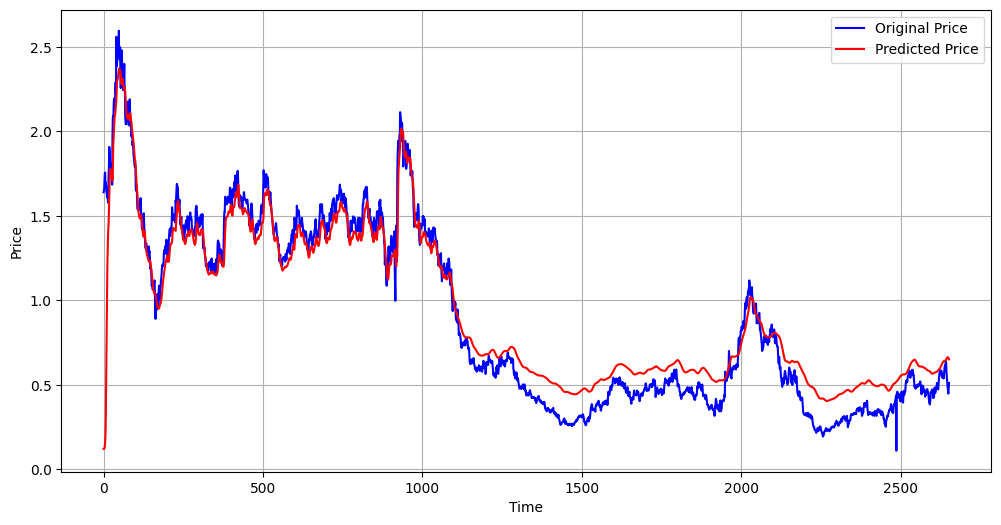

In [35]:
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Random Forest Classifier